In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from importlib import reload, import_module
import itertools
import glob
import os
import numpy as np
import tensorflow as tf
import scipy
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import deepxde_master as dde
# dde = import_module('deepxde_master')
# dde = reload(dde) # reload if it is changed

# import deepxde_master as dde

from spaces import FinitePowerSeries, FiniteChebyshev, GRF
from system_pde import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem
from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Advection Equation
$$
\frac{\partial s}{\partial t}+a(x) \frac{\partial s}{\partial x}=0, \quad x \in[0,1], t \in[0,1] \\
s(x,0)=u(x)
$$


# Auxilliary Function

In [2]:
def create_dir(d):
    """ Create a directory if it does not exist
    Args:
        d: directory to create
    """
    if not os.path.exists(d):
        os.makedirs(d)


def test_u_cvc(nn, system, T, m, model, data, u, fname):
    """Test Advection"""
    sensors = np.linspace(0, 1, num=m)
#     sensor_value = u(np.sin(np.pi*sensors)**2)
    sensor_value = u(sensors)
    s = system.eval_s(sensor_value)
    xt = np.array(list(itertools.product(range(m), range(system.Nt))))
    xt = xt * [1 / (m - 1), T / (system.Nt - 1)]
    X_test = [np.tile(sensor_value, (m * system.Nt, 1)), xt]
    y_test = s.reshape([m * system.Nt, 1])
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    y_test_f = y_test.reshape((m, system.Nt))[:,-1]
    y_pred_f = y_pred.reshape((m, system.Nt))[:,-1]
    x, t = xt[:, 0], xt[:, 1]
    x_f = x.reshape((m, system.Nt))[:,-1]
    t_f = x.reshape((m, system.Nt))[:,-1]
#     np.savetxt(fname, np.hstack((xt, y_test, y_pred)))
    plt.figure()
    plt.plot(x_f, y_test_f, 'b-', label='true value')
    plt.plot(x_f, y_pred_f, 'r--', label='prediction')
    plt.title(f"$s(x,t_f)$ with $u(x)={fname[:-4]}$")
    plt.legend()

def cvc_system(T, npoints_output):
    """Advection"""
    f = None
    g = None
    Nt = 100
    return CVCSystem(f, g, T, Nt, npoints_output)



# Problem Setup and Hyperparameters

In [3]:
problem = "cvc"
T = 1
# system = ode_system(T)
npoints_output = 10
system = cvc_system(T, npoints_output)

def pde(inputs, s):
    a = 1.0
    u = inputs[0]
    coord = inputs[1]
    x = coord[:,0:1]
    t = coord[:,1:2]
    print(f"inputs: {inputs}")
    print(f"s: {s}")
    ds_dt = dde.grad.jacobian(s, coord, i=0, j=1)
    ds_dx = dde.grad.jacobian(s, coord, i=0, j=0)
    # ds_dt = dde.grad.jacobian(s, t, i=0, j=0)
    # ds_dx = dde.grad.jacobian(s, x, i=0, j=0)
    eq = ds_dt + a*ds_dx
    return eq

def ic(inputs, s):
    u = inputs[0]
    coord = inputs[1]
    eq = s - u
    return eq

def bc(inputs, s):
    u = inputs[0]
    coord = inputs[1]
    eq = s[1] - s[0]
    return eq

ic_points = 1000
bc_points = None
# Function space
space = GRF(T, length_scale=0.2, N=1000 * T, interp="cubic")
# space = GRF(T, length_scale=0.5, N=1000 * T, interp="cubic")

# Hyperparameters
m = 100
num_train = 1000 #10000
num_test = 1000 # 10000
lr = 0.001
epochs = 10000

# Network
nn = "opnn"
activation = "tanh" #"relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
model_name = 'deeponet' 
model_name_PI = 'deeponet-phys'
dim_x = 1 if problem in ["ode", "ode_nonlinear", "ode_pendulum", "lt"] else 2
net = dde.maps.DeepONet(
        [m, 40, 40],
        [dim_x, 40, 40],
        activation="relu",
        kernel_initializer=initializer,
        use_bias=True,
        stacked=False,
    )

net_PI = dde.maps.DeepONet(
        [m, 40, 40],
        [dim_x, 40, 40],
        activation,
        initializer,
        use_bias=True,
        stacked=False,
    )



# Generate Training Data

In [4]:
X_train, y_train, ic_coord = system.gen_operator_data(space, m, num_train)
X_test, y_test, _ = system.gen_operator_data(space, m, num_test)
ic_times = np.zeros((len(ic_coord), 1))
ic_coord = np.hstack((ic_coord, ic_times))

Generating operator data...
'gen_operator_data' took 1.791565 s

Generating operator data...
'gen_operator_data' took 1.758837 s



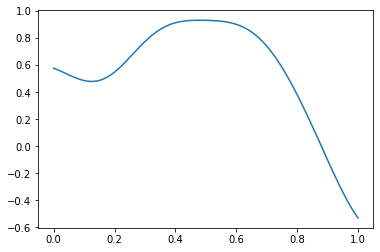

In [5]:
import matplotlib.pyplot as plt
u,coord = X_train
# plt.plot(sensors,u)
u0 = u[0]
x = coord[0]
plt.plot(ic_coord[:,0:-1],u0)



# DeepONeT

In [6]:
data = dde.data.Triple(
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
    )

model = dde.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
ckpt_dir = f"{problem}/{model_name}"
create_dir(ckpt_dir)
ckpt_filename = "model.ckpt"
ckpt_file = os.path.join(ckpt_dir,ckpt_filename)
checker = dde.callbacks.ModelCheckpoint(
    ckpt_file, save_better_only=True, period=1000
)

Compiling model...
Building DeepONet...
'build' took 0.117628 s



/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.272900 s



# Physics Informed DeepONet 

In [11]:
data_PI = dde.data.TriplePI(
            X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test, 
            pde=pde,
            # ic=ic,
            bc=None,
            ic_coord=ic_coord,
            bc_coord=None,
            ic_points=1000,
            bc_points=None
            )
model_PI = dde.Model(data_PI, net_PI)
# model_PI.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
model_PI.compile("adam", lr=lr)
ckpt_dir_PI = f"{problem}/{model_name_PI}"
create_dir(ckpt_dir_PI)
ckpt_filename_PI = "model.ckpt"
ckpt_file_PI = os.path.join(ckpt_dir_PI,ckpt_filename_PI)
checker_PI = dde.callbacks.ModelCheckpoint(
    ckpt_file_PI, save_better_only=True, period=1000
)

Compiling model...
pde_inputs: (<tf.Tensor 'Placeholder_7:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'Placeholder_8:0' shape=(None, 2) dtype=float32>)
outputs: Tensor("add_1:0", shape=(None, 1), dtype=float32)
inputs: (<tf.Tensor 'Placeholder_7:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'Placeholder_8:0' shape=(None, 2) dtype=float32>)
s: Tensor("add_1:0", shape=(None, 1), dtype=float32)
'compile' took 0.259127 s



# Train the Models

## Train the DeepONeT Model

In [12]:
losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])

Initializing variables...
Training model...

0         [8.51e-01]                        [8.39e-01]                        [8.23e-01]
1000      [2.65e-02]                        [3.20e-02]                        [2.85e-02]
INFO:tensorflow:cvc/deeponet/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [1.78e-02]                        [2.17e-02]                        [1.92e-02]
INFO:tensorflow:cvc/deeponet/model.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.
3000      [1.19e-02]                        [1.50e-02]                        [1.35e-02]
INFO:tensorflow:cvc/deeponet/model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.
4000      [9.11e-03]                        [1.21e-02]                        [1.11e-02]
INFO:tensorflow:cvc/deeponet/model.ckpt-4000 is not in all_model_checkpoint_paths. Manually adding it.
5000      [7.18e-03]                        [1.01e-02]                        [9.23e-03]
INFO:tens

## Train the Physics Informed DeepONet Model

In [13]:
losshistory_PI, train_state_PI = model_PI.train(epochs=epochs, callbacks=[checker_PI])

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.05e+00, 1.32e+00, 1.45e+00]    [1.98e+00, 1.30e+00, 1.36e+00]    []  
1000      [4.78e-01, 3.44e-03, 6.29e-01]    [4.98e-01, 3.38e-03, 6.19e-01]    []  
INFO:tensorflow:cvc/deeponet-phys/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [2.14e-01, 4.94e-03, 6.39e-01]    [2.28e-01, 4.91e-03, 6.37e-01]    []  
INFO:tensorflow:cvc/deeponet-phys/model.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.


Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
Traceback (most recent call last):
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/mnt/c/Users/shawn/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._targe

KeyboardInterrupt: 